In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.mapping import rc_to_nest, get_reaction_center
from ergochemics.draw import draw_reaction, draw_molecule
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from minedatabase.pickaxe import Pickaxe

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [15]:
expansion_name = "2_steps_ccm_aa_aplusb_True"
cpd_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_compound_metrics.parquet")
cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]}).reset_index()
cpd_df.head(24)

expansion gen     fan_out  \
                                                                 mean   
0   2_steps_ccm_aa_rules_imt_rules_w_coreactants_a...   0  164.793103   
1   2_steps_ccm_aa_rules_imt_rules_w_coreactants_a...   1   60.714286   
2   2_steps_ccm_aa_rules_mechinferred_dt_15_rules_...   0  166.689655   
3   2_steps_ccm_aa_rules_mechinferred_dt_15_rules_...   1   36.008237   
4   2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...   0   86.724138   
5   2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...   1   21.681499   
6   2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w...   0  119.310345   
7   2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w...   1   26.777070   
8   2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w...   0  137.034483   
9   2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w...   1   28.583650   
10  2_steps_ccm_aa_rules_mechinferred_dt_98_rules_...   0  186.724138   
11  2_steps_ccm_aa_rules_mechinferred_dt_98_rules_...   1   44.057851   
12  2_steps_ccm_aa_rules_mechinformed_rules_w_core...   0  111.896552   
13  2_steps_ccm_aa_rules_mechinformed_rules_w_core...   1   26.923077   
14  2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...   0  387.931034   
15  2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreact...   1  214.558548   
16  2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreact...   0   68.068966   
17  2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreact...   1   20.415094   
18  2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreact...   0   30.034483   
19  2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreact...   1   11.021053   
20  2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreact...   0   13.758621   
21  2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreact...   1    7.352941   
22  2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...   0   13.137931   
23  2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreact...   1    6.560386   

                 
            std  
0    292.132110  
1     41.250251  
2    204.523855  
3     27.099102  
4    117.871570  
5     15.475309  
6    154.962231  
7     20.730161  
8    191.619877  
9     21.224775  
10   261.401429  
11    37.749986  
12   194.829659  
13    20.073932  
14  1015.279094  
15   194.008915  
16    75.831548  
17    13.402387  
18    35.764590  
19     5.461734  
20     6.711691  
21     3.603326  
22     7.740082  
23     3.122884

In [4]:
rxn_df = pd.read_parquet(Path(cfg.processed_data) / f"{expansion_name}_reaction_metrics.parquet")
rxn_df.head()

,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion
0,Ra5466f30b2eff8d962354506782f3c774e2dbccfeabcc...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,[O:1]=[c:2]1[cH:3][cH:4][n:5]([CH:6]2[O:7][CH:...,1,1.000000,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C...,6795,[813_1],2_steps_ccm_aa_rules_mechinformed_rules_w_core...
1,R1a6f3d7e229c81ffd5e77b63a4191e793232130cbc0e0...,O=C(O)CCC(=O)O.CC(N)C(=O)O>>CC(NC(=O)CCC(=O)O)...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,1,0.848875,O=C(O)CCC(=O)O.NC(CCC(=O)O)C(=O)O>>O=C(O)CCC(=...,197,"[8_0_0, 8_0_0_0, 8_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
2,Ra9e6706c0b8df38fa1056bb4ad1ac443a60e95f3e02f1...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,[O:1]=[c:2]1[cH:3][cH:4][n:5]([CH:6]2[O:7][CH:...,1,0.960000,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C...,19866,[558_1],2_steps_ccm_aa_rules_mechinformed_rules_w_core...
3,Rec6d7525917f77e5f6c7a5942c1b7197b67be650c7476...,O=C(O)CCC(=O)O.O=C(O)CCC(=O)O>>O.O=C(O)CCC(=O)...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,0,0.710047,O=C(O)CCC(=O)O.CCCCCCCCCCCCCCCCOCC(O)COP(=O)(O...,4622,"[167_0_1, 167_0_0, 167_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...
4,R3b25a7e0bed159020e2a34dc51c3cf7529c6ec4038177...,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,0,0.947368,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O...,2190,"[333_1, 382_1, 631_1]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...


In [6]:
rxn_df.groupby("expansion").agg({"dxgb_label": ["mean", "std"], "max_rxn_sim": ["mean", "std"]}).head(12)

dxgb_label            \
                                                         mean       std   
expansion                                                                 
2_steps_ccm_aa_rules_imt_rules_w_coreactants_ap...   0.285790  0.451793   
2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w...   0.453385  0.497833   
2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_...   0.544323  0.498057   
2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_...   0.515559  0.499777   
2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_...   0.489283  0.499901   
2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w...   0.442432  0.496682   
2_steps_ccm_aa_rules_mechinformed_rules_w_corea...   0.402511  0.490425   
2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreacta...   0.226053  0.418274   
2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreacta...   0.502010  0.500023   
2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreacta...   0.640449  0.479938   
2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreacta...   0.648188  0.477663   
2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreacta...   0.658920  0.474221   

                                                   max_rxn_sim            
                                                          mean       std  
expansion                                                                 
2_steps_ccm_aa_rules_imt_rules_w_coreactants_ap...    0.557559  0.277577  
2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w...    0.695231  0.219822  
2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_...    0.757806  0.192739  
2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_...    0.733621  0.204861  
2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_...    0.723593  0.206863  
2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w...    0.638410  0.225012  
2_steps_ccm_aa_rules_mechinformed_rules_w_corea...    0.718987  0.208636  
2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreacta...    0.422318  0.283358  
2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreacta...    0.828883  0.129049  
2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreacta...    0.892192  0.082403  
2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreacta...    0.897864  0.091438  
2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreacta...    0.893510  0.096501

In [8]:
ct_data = []
for exp in rxn_df.expansion.unique():
    pk = Pickaxe()
    pk.load_pickled_pickaxe(Path(cfg.interim_data) / exp)
    ct_data.append([exp, len(pk.reactions), len(pk.compounds)])

ct_df = pd.DataFrame(
    data=ct_data,
    columns=["expansion", "n_rxns", "n_cpds"]
)
ct_df.head()

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 6629 compounds
Loaded 11711 reactions
Loaded 757 operators
Loaded 66 coreactants
Loaded 2 generation
Took 0.1147613525390625
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_imt_rules_w_coreactants_aplusb_True.pk pickled data.


[10:08:57] WARNING: not removing hydrogen atom without neighbors
[10:08:59] WARNING: not removing hydrogen atom without neighbors


Loaded 49241 compounds
Loaded 80395 reactions
Loaded 1852 operators
Loaded 64 coreactants
Loaded 2 generation
Took 1.0994923114776611
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:01] WARNING: not removing hydrogen atom without neighbors


Loaded 6259 compounds
Loaded 9809 reactions
Loaded 7335 operators
Loaded 71 coreactants
Loaded 2 generation
Took 1.8137545585632324
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:02] WARNING: not removing hydrogen atom without neighbors


Loaded 8066 compounds
Loaded 13245 reactions
Loaded 6236 operators
Loaded 70 coreactants
Loaded 2 generation
Took 1.137822151184082
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:03] WARNING: not removing hydrogen atom without neighbors


Loaded 9248 compounds
Loaded 15729 reactions
Loaded 5473 operators
Loaded 69 coreactants
Loaded 2 generation
Took 0.8194863796234131
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:04] WARNING: not removing hydrogen atom without neighbors


Loaded 13600 compounds
Loaded 22671 reactions
Loaded 3746 operators
Loaded 67 coreactants
Loaded 2 generation
Took 0.4851841926574707
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:05] WARNING: not removing hydrogen atom without neighbors


Loaded 20312 compounds
Loaded 32908 reactions
Loaded 2207 operators
Loaded 65 coreactants
Loaded 2 generation
Took 0.41885852813720703
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:10] WARNING: not removing hydrogen atom without neighbors


Loaded 372224 compounds
Loaded 702208 reactions
Loaded 1453 operators
Loaded 58 coreactants
Loaded 2 generation
Took 5.388671398162842
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:11] WARNING: not removing hydrogen atom without neighbors


Loaded 5756 compounds
Loaded 9210 reactions
Loaded 3853 operators
Loaded 71 coreactants
Loaded 2 generation
Took 0.41985154151916504
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:12] WARNING: not removing hydrogen atom without neighbors


Loaded 2273 compounds
Loaded 3477 reactions
Loaded 5266 operators
Loaded 72 coreactants
Loaded 2 generation
Took 0.7471966743469238
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk pickled data.


[10:09:13] WARNING: not removing hydrogen atom without neighbors


Loaded 1373 compounds
Loaded 1881 reactions
Loaded 6351 operators
Loaded 74 coreactants
Loaded 2 generation
Took 1.113335132598877
----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 1176 compounds
Loaded 1597 reactions
Loaded 7204 operators
Loaded 74 coreactants
Loaded 2 generation
Took 1.5011742115020752


[10:09:15] WARNING: not removing hydrogen atom without neighbors


,expansion,n_rxns,n_cpds
0,2_steps_ccm_aa_rules_mechinformed_rules_w_core...,11711,6629
1,2_steps_ccm_aa_rules_imt_rules_w_coreactants_a...,80395,49241
2,2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w...,9809,6259
3,2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w...,13245,8066
4,2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w...,15729,9248


In [73]:
exp_names = list(rxn_df.expansion.unique())
perm = [0, 1, 6, 5, 4, 3, 2, 7, 8, 9, 10, 11]  # for plotting in order of increasing RC
exp_names = [exp_names[p] for p in perm]
exp_labels = {
    '2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_ccm_aa_rules_imt_rules_w_coreactants_aplusb_True.pk': "Ni intermediate",
    '2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.98",
    '2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.15",
    '2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.06",
    '2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.03",
    '2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.02"
}

colors = {
    '2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_ccm_aa_rules_imt_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("blue"),
    '2_steps_ccm_aa_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk':matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_ccm_aa_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_ccm_aa_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_ccm_aa_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_ccm_aa_rules_mechinferred_dt_98_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_ccm_aa_rules_mechinferred_dt_15_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_ccm_aa_rules_mechinferred_dt_6_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_ccm_aa_rules_mechinferred_dt_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_ccm_aa_rules_mechinferred_dt_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0)
}

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

In [26]:
print(matplotlib.colors.to_rgba("blue"))
print(matplotlib.colors.to_rgba("purple"))
print(matplotlib.colors.to_rgba("black"))
print(matplotlib.colors.to_rgba("green"))

(0.0, 0.0, 1.0, 1.0)
(0.5019607843137255, 0.0, 0.5019607843137255, 1.0)
(0.0, 0.0, 0.0, 1.0)
(0.0, 0.5019607843137255, 0.0, 1.0)


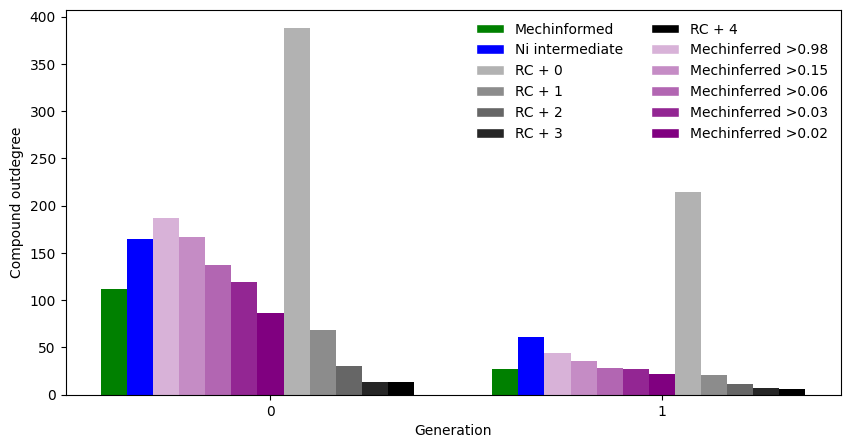

In [41]:
# Fan out clustered bar graph

gens = cpd_df.gen.unique()
scl_space = 1.5
n_bars = len(exp_labels)
width = 0.1

fig, ax = plt.subplots(figsize=(10, 5))

for gen in gens:
    ctr = gen * scl_space
    for i in range(n_bars):
        tick = ctr - ((n_bars * width) / 2) + (i * width)
        exp_name = exp_names[i]
        mean_fan_out = cpd_df.loc[(cpd_df["gen"] == gen) & (cpd_df["expansion"] == exp_name), "fan_out"]["mean"].values[0]
        label = exp_labels[exp_name]
        color = colors[exp_name]
        ax.bar(tick, height=mean_fan_out, width=width, color=color, label=label)
ax.set_xticks(gens * scl_space)
ax.set_xticklabels(gens.astype(int))

ax.set_xlabel("Generation")
ax.set_ylabel("Compound outdegree")
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
plt.show()
        

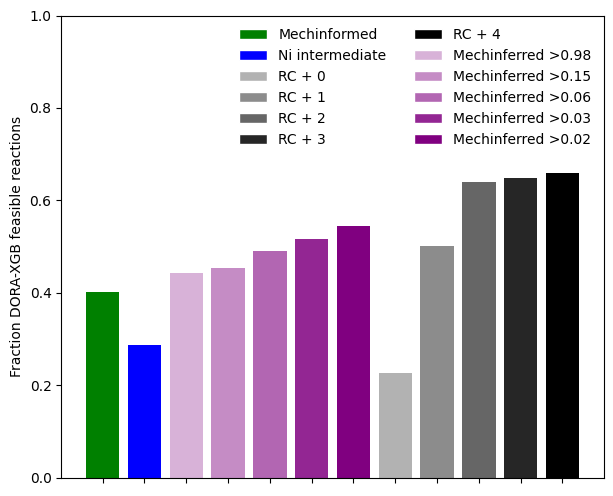

In [43]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Fraction DORA-XGB feasible reactions")
plt.show()

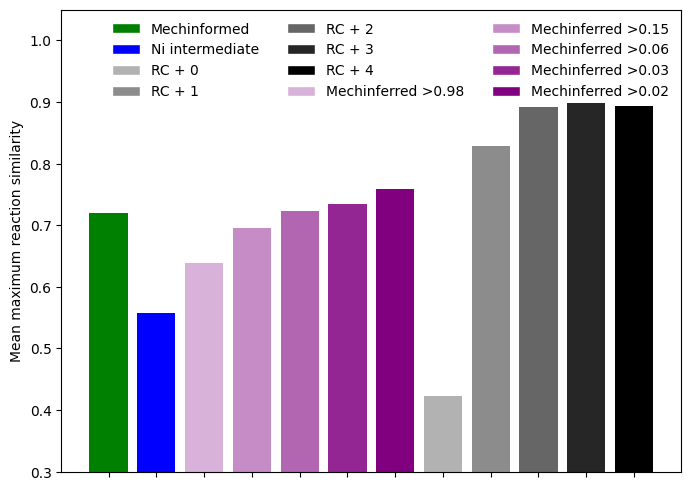

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.8
for exp_name in exp_names:
    mean = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=mean, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=False, fontsize=10)
ax.set_ylim(0.3, 1.05)
ax.set_ylabel("Mean maximum reaction similarity")
plt.show()

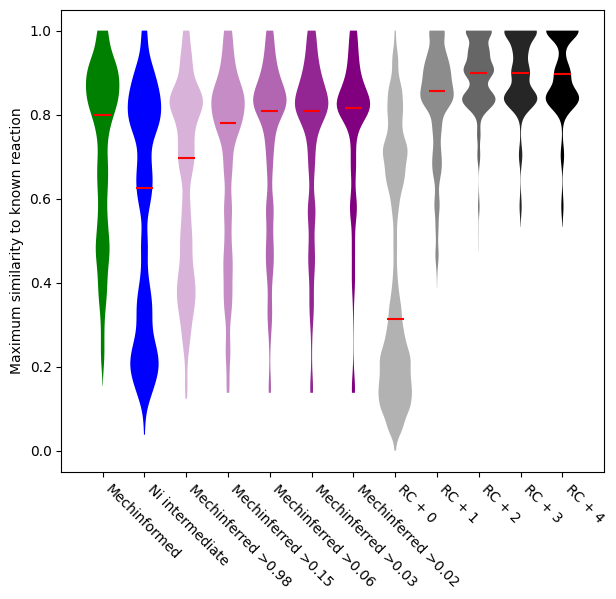

In [79]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
data = []
xticklabels = []
positions = []
_colors = []
_alphas = []
for i, exp_name in enumerate(exp_names):
    data.append(rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"])
    xticklabels.append(exp_labels[exp_name])
    positions.append(i)
    _colors.append(tuple(elt for elt in colors[exp_name][:-1]))
    _alphas.append(colors[exp_name][-1])  # store alpha for violin plot

vparts = ax.violinplot(data, positions=positions, widths=width, showmeans=False, showmedians=True, showextrema=False)

for color, alpha, vp in zip(_colors, _alphas, vparts['bodies']):
    vp.set_facecolor(color)
    # vp.set_edgecolor('black')
    vp.set_alpha(alpha)

vparts["cmedians"].set_color("red")

ax.set_xticks(positions)
ax.set_xticklabels(labels=xticklabels, rotation=-45, ha='left')
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("Maximum similarity to known reaction")
plt.show()

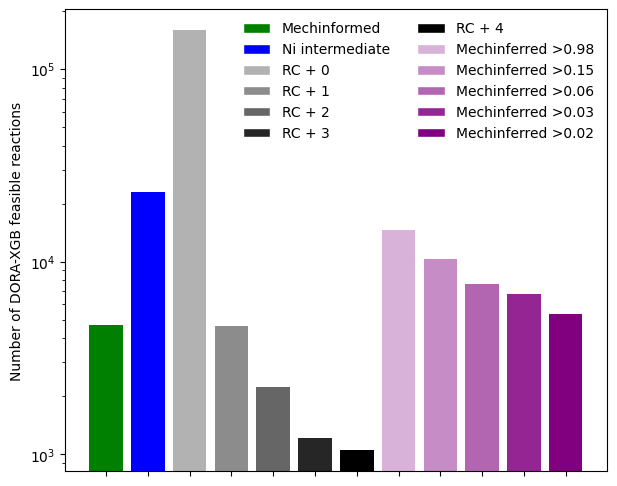

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac * tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Number of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.show()

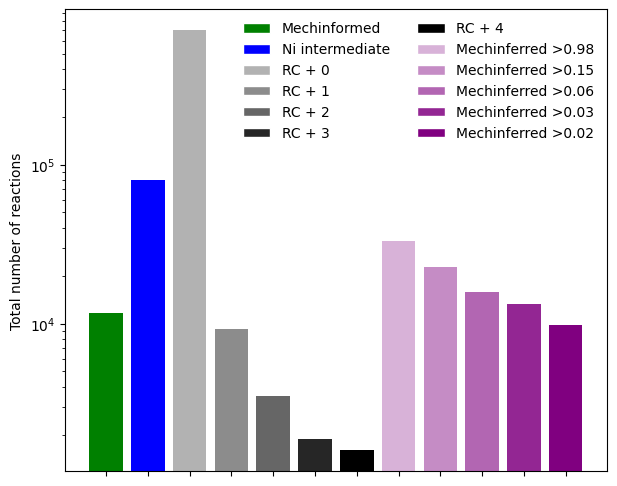

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_yscale('log')
plt.show()

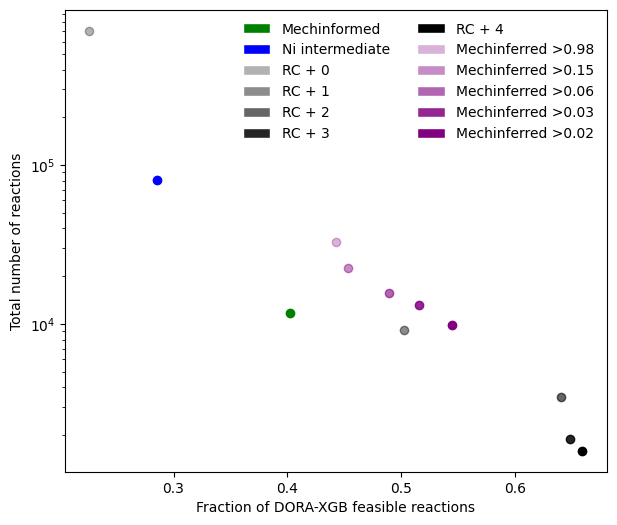

In [84]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color)


ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")

ax.set_yscale('log')
plt.show()

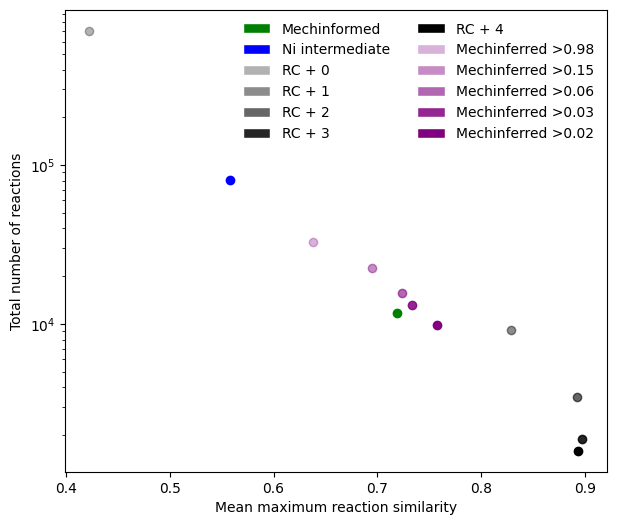

In [85]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    mean_max_sim = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.plot(mean_max_sim, tot_rxns, marker='o', color=color)


ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Mean maximum reaction similarity")

ax.set_yscale('log')
plt.show()